# 分析

In [1]:
# 1. ライブラリのインポート
# vscodeで実行する場合にはipykernelパッケージが必要

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
# 2. グラフの設定

plt.style.use('fast') # スタイルの設定
plt.rcParams['figure.figsize'] = [9, 5] # サイズの設定

In [3]:
# 3. DataFrameの作成

file_path = "../data/BloodDonation.csv"
df = pd.read_csv(file_path)

# date列を作成
df['date'] = pd.to_datetime((df['year'].astype(str)) + '-' + (df['month'].astype(str)))

### 変動成分の分解

**傾向変動（Trend）：**<br>
データの長期的な傾向や一定の方向性で少しづつ変化する動きのこと。<br>

**循環変動（Cycle）：**<br>
傾向変動より短期的で周期的に繰り返される動きのこと。<br>

**季節変動（Seasonal）：**<br>
データの周期的な変動のこと。通常1年を周期とする。<br>

**不規則変動（Irregular）：**<br>
トレンド、季節変動、循環変動では説明できない短期的かつ不規則な動きのこと。残差、ノイズとも呼ばれる。

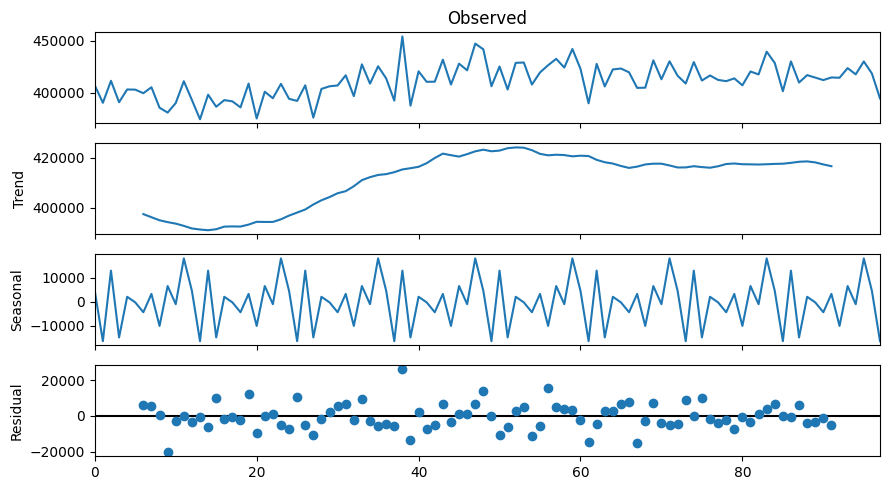

In [4]:
# dateごとの全国のblood_donorsでグループ化
grouped_date_total = df.groupby(['date'])['blood_donors'].sum().to_frame()

# トレンド、季節性、残差を求める（加法モデル）
res_additive = sm.tsa.seasonal_decompose(grouped_date_total.values, period=12, model='additive')

# グラフ化
fig = res_additive.plot()
plt.show()

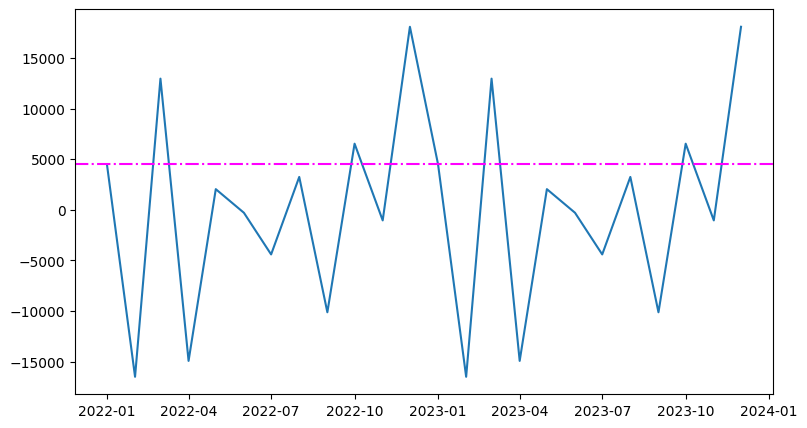

In [5]:
s = res_additive.seasonal[60]

additive_seasona = res_additive.seasonal[60:84]

# トレンド、季節性、残差を求める（加法モデル）
plt.plot(grouped_date_total.index[60:84], additive_seasona)
plt.axhline(s, ls = "-.", color = "magenta")
plt.show()

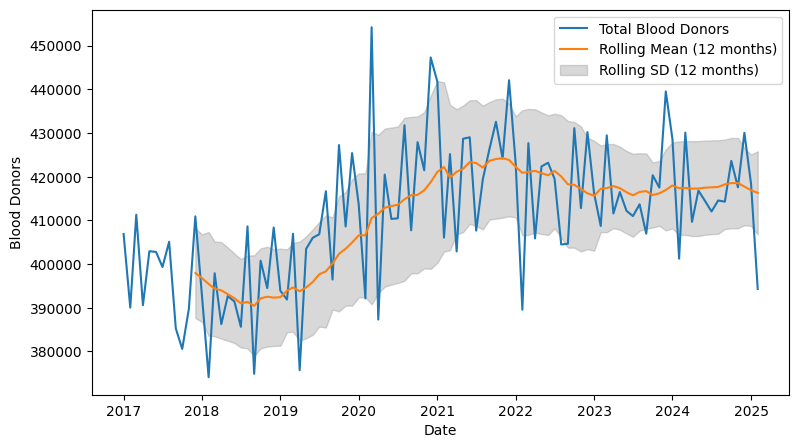

In [6]:
df_s = df.groupby(['date'])["blood_donors"].sum()

rolling_mean = df_s.rolling(window=12).mean()  # 12ヶ月の移動平均
rolling_sd = df_s.rolling(window=12).std()     # 12ヶ月の移動標準偏差

plt.plot(df_s, label='Total Blood Donors')
plt.plot(rolling_mean, label='Rolling Mean (12 months)')
plt.fill_between(df_s.index, rolling_mean - rolling_sd, rolling_mean + rolling_sd, color='gray', alpha=0.3, label='Rolling SD (12 months)')

plt.xlabel('Date')
plt.ylabel('Blood Donors')
plt.legend()
plt.show()

加法モデル：<br>
`statsmodels`ライブラリの`seasonal_decompose`関数を使用した加法モデルは、時系列データから季節性を取り除くための手法で、データから季節的なパターンが除去され、より安定したトレンドや周期性が明確になる。**移動平均法**に基づいた手法

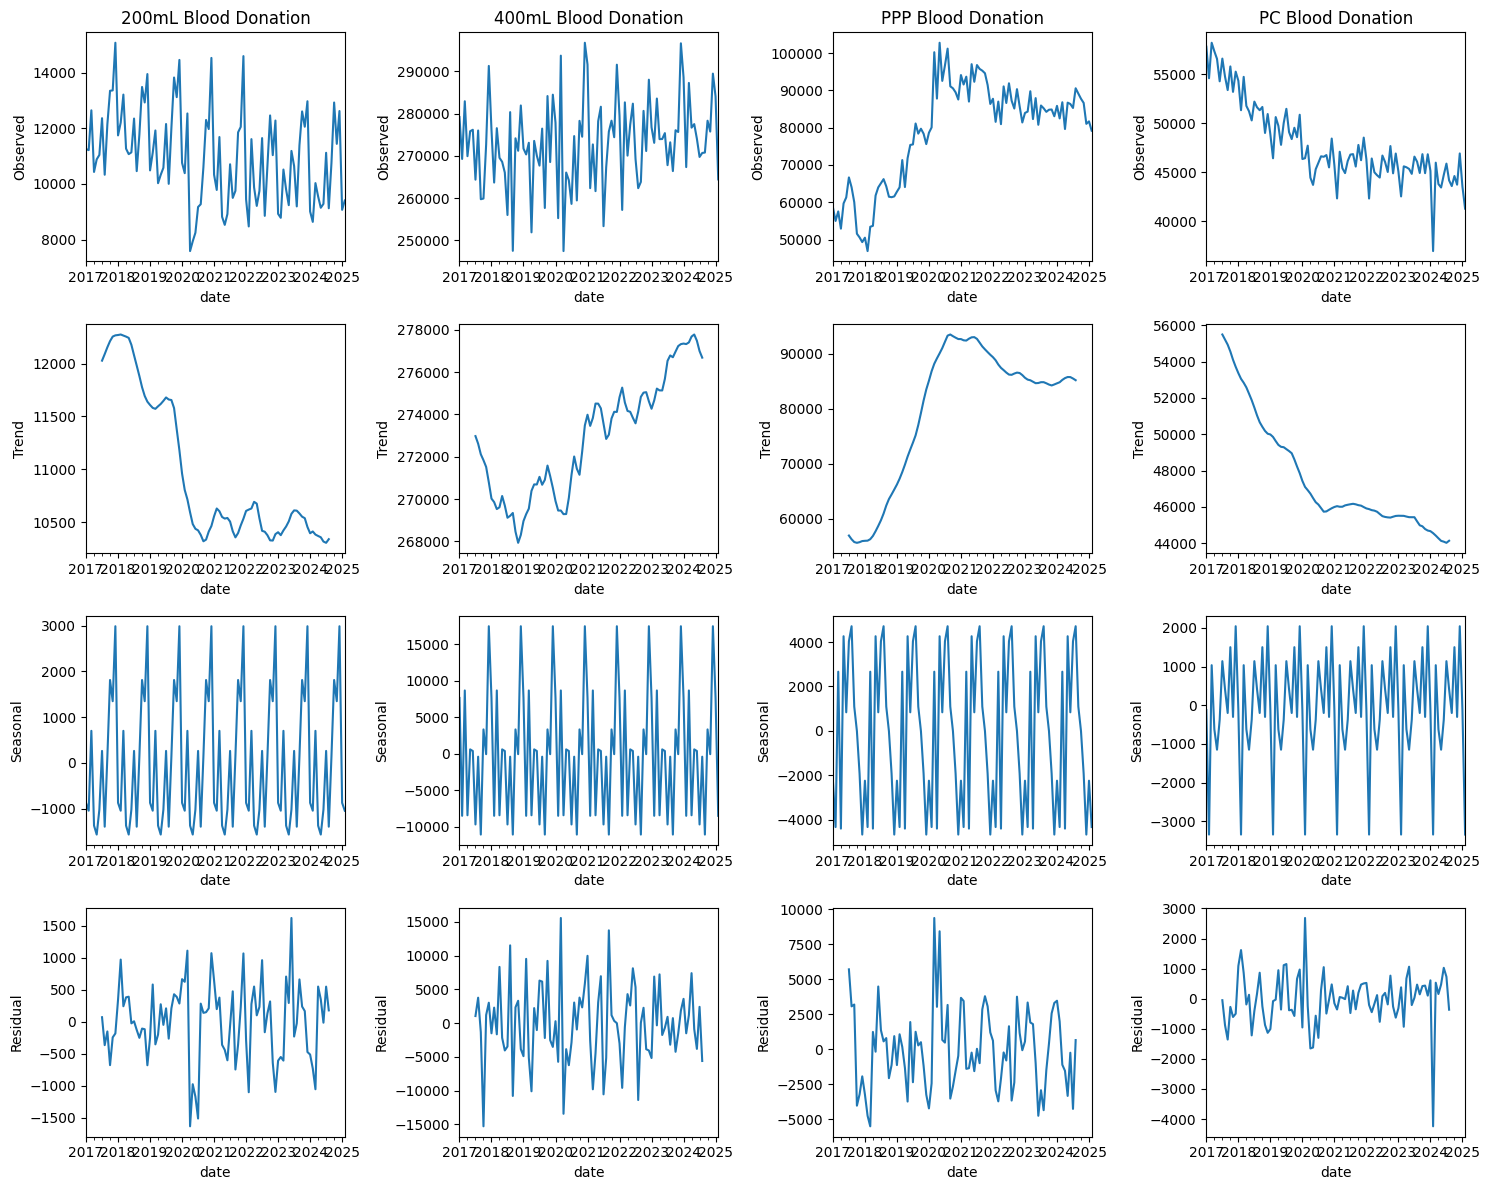

In [7]:
# 献血方法別変動成分の分解

# dateごとにグループ化
df_2bd = df.groupby(['date'])['200mL_blood_donation'].sum().to_frame()
df_4bd = df.groupby(['date'])['400mL_blood_donation'].sum().to_frame()
df_pbd = df.groupby(['date'])['PPP_blood_donation'].sum().to_frame()
df_cbd = df.groupby(['date'])['PC_blood_donation'].sum().to_frame()

# トレンド、季節性、残差を求める（加法モデル）
res_additive_2bd = sm.tsa.seasonal_decompose(df_2bd, period=12, model="additive")
res_additive_4bd = sm.tsa.seasonal_decompose(df_4bd, period=12, model="additive")
res_additive_pbd = sm.tsa.seasonal_decompose(df_pbd, period=12, model="additive")
res_additive_cbd = sm.tsa.seasonal_decompose(df_cbd, period=12, model="additive")

fig, axs = plt.subplots(4, 4, figsize=(15, 12))

def plot(ax, result, title):
    result.observed.plot(ax=ax[0], legend=False)
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1], legend=False)
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2], legend=False)
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3], legend=False)
    ax[3].set_ylabel('Residual')
    ax[0].set_title(title)

# 各グラフのプロット
plot(axs[:, 0], res_additive_2bd, '200mL Blood Donation')
plot(axs[:, 1], res_additive_4bd, '400mL Blood Donation')
plot(axs[:, 2], res_additive_pbd, 'PPP Blood Donation')
plot(axs[:, 3], res_additive_cbd, 'PC Blood Donation')

plt.tight_layout()
plt.show()

200mL、PC（血小板）献血者数は減少傾向にある

### 定常性検定

**定常性：**<br>
時間によらず統計的な特性（平均、分散、自己相関など）が一定であるような時系列データの性質。定常性が満たされていると、過去のデータから未来のデータを予測する信頼性がより高くなるため、時系列データの解析やモデリングが容易になる。<br>

**差分変換：**<br>
非定常性を除去する定常化手法の一つで、1期前のデータとの差分を計算し階差系列を得る。ただし、一階差分を計算すると、最初の行が欠損値になるためそれを削除するために`.dropna()`を用いる。

**ADF検定：**<br>
定常性検定の代表的な手法の一つで、単位根の有無を検定する。<br><br>
ーADF検定の流れー<br>
1. 帰無仮説を対立仮説を立てる<br>
   - 帰無仮説$H_0$：時系列は定常である（単位根を持つ）
   - 対立仮説$H_1$：時系列は定常ではない（単位根を持たない
2. 検定量の比較<br>
   一般的にp値の閾値(有意水準)として0.05が用いられる。p値が0.05より小さいとき**5%有意**といい、帰無仮説を棄却し対立仮説を採択する。また、ADF統計量が5%の**棄却限界値**より小さいとき**5%有意**といい、帰無仮説を棄却し対立仮説を採択する。<br>
   すなわち、p値とADF統計量の両方が5%の有意水準を下回る場合、時系列は定常である可能性が高いことを示唆する。

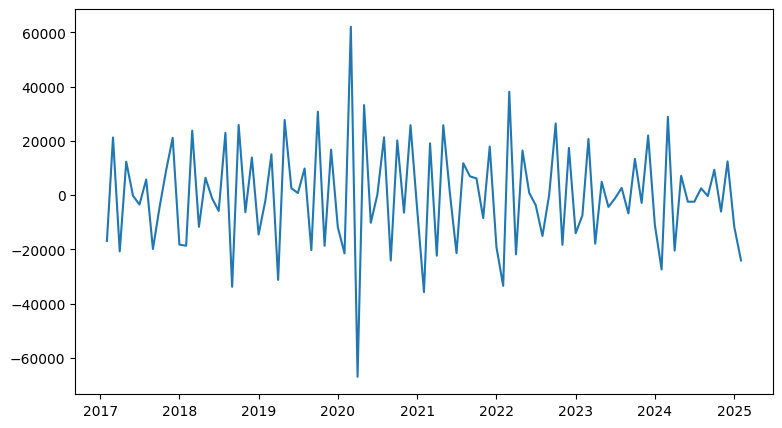

--- diff ---
ADF Statistic: -3.102680
p-value: 0.026355
Critical values :
	 1% -3.510711795769895
	 5% -2.8966159448223734
	 10% -2.5854823866213152


In [8]:
# 差分変換
df_diff = grouped_date_total.diff(1).dropna()
plt.plot(df_diff)
plt.show()

# ADF検定
dftest = adfuller(df_diff)
print("--- diff ---")
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

- ADF統計量は-4.775412であり5%の棄却限界値を下回っているので5%有意<br>
- p値は0.000061であり5%の棄却限界値を下回っているので5%有意<br>
よって、帰無仮説（時系列は非定常である）は棄却され、対立仮説（時系列は定常である）が採択された。<br>
すなわち、定常性が認められた。👏

### 相関分析
2つ以上の変数間の関係性を定量的に評価するための統計手法で、変数間の関連性の強さと方向性を理解することができる。<br>
**自己相関（ACF）：**<br>
さまざまなラグ（遅れ）での自己相関を示す関数。ACFプロットを使用することで、時系列データ内の観測値が過去の自身とどの程度関連しているかを視覚的に評価することができる。<br>
**偏自己相関（PACF）：**<br>
中間のラグの影響を除いた特定のラグでの偏自己相関を示す関数。偏自己相関関数を用いることで、直接的なラグの影響を評価することができる。

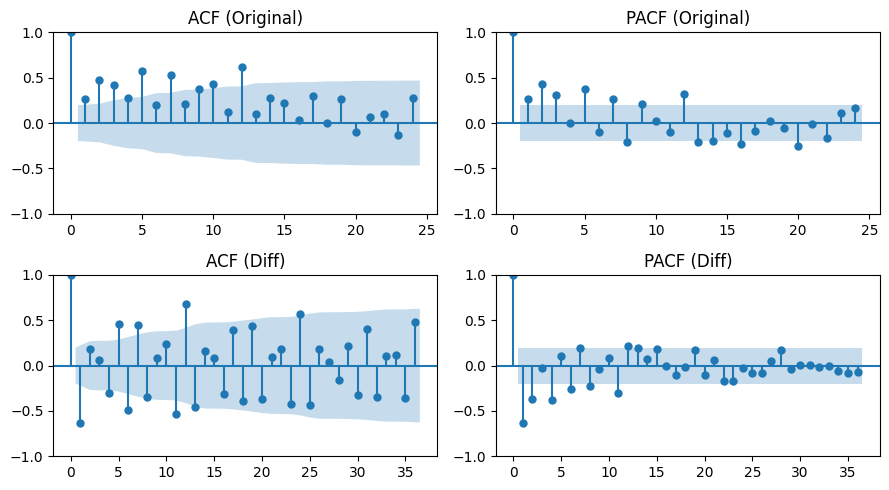

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# サブプロットの作成
fig, axes = plt.subplots(2, 2)

# ACFとPACFをプロット
plot_acf(grouped_date_total, lags=24, ax=axes[0, 0])
plot_pacf(grouped_date_total, lags=24, ax=axes[0, 1])

# 差分変換したデータのACFとPACFをプロット
df_diff = grouped_date_total.diff(1).dropna()
plot_acf(df_diff, lags=36, ax=axes[1, 0])
plot_pacf(df_diff, lags=36, ax=axes[1, 1])

# グラフのタイトルを設定
axes[0, 0].set_title('ACF (Original)')
axes[0, 1].set_title('PACF (Original)')
axes[1, 0].set_title('ACF (Diff)')
axes[1, 1].set_title('PACF (Diff)')

# グラフを表示
plt.tight_layout()
plt.show()

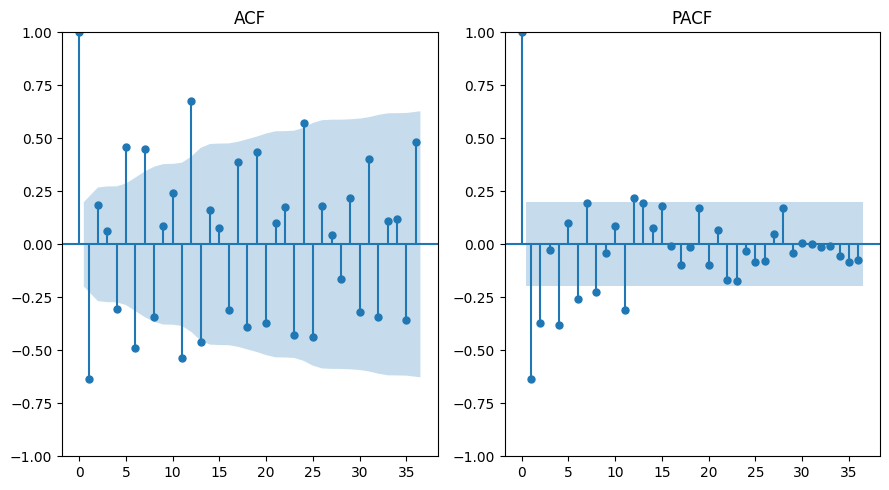

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# サブプロットの作成
fig, axes = plt.subplots(1, 2)

# 差分変換したデータのACFとPACFをプロット
plot_acf(df_diff, lags=36, ax=axes[0])
plot_pacf(df_diff, lags=36, ax=axes[1])

# グラフのタイトルを設定
axes[0].set_title('ACF')
axes[1].set_title('PACF')

# グラフを表示
plt.tight_layout()
plt.show()


### 参考にしたサイト等
https://www.kaggle.com/code/anguillajaponica/time-series-basics